In [1]:
import pandas as pd
import numpy as np
import pyodbc
import sklearn as sk
import tensorflow as tf
import json

2022-09-10 17:45:03.361488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-10 17:45:04.446472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-10 17:45:04.446504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-10 17:45:04.556268: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-10 17:45:07.718027: W tensorflow/stream_executor/platform/de

In [16]:
# Setup SQL
global con, cur
with open(r"./sql-config.json") as f:
    sql_config = json.load(f)
con = pyodbc.connect(
    "Driver={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.0.so.1.1};"
    "TrustServerCertificate=yes;"
    f"Server={sql_config['ip']},{sql_config['port']};"
    f"Database={sql_config['database']};"
    f"UID={sql_config['uid']};"
    f"PWD={sql_config['password']};"
)
cur = con.cursor()

In [17]:
# Pull all data from FatTrimmerData into df
df = pd.DataFrame()
sql = "SELECT * FROM FatTrimmerData;"
for chunk in pd.read_sql(sql, con, chunksize=10000):
    df = pd.concat([df, chunk])

In [18]:
# Remove useless Batch column
df.drop('Batch',axis=1,inplace=True)
# Remove any rows where DeltaTime is -1
df = df[df.DeltaTime != -1]
# Drop any duplicate rows incase scraping makes a mistake
df.drop_duplicates(inplace=True)
# Convert NewItems bool -> int
df["NewItems"] = df["NewItems"].astype(int)

In [23]:
# Filter a % of False "NewItems"
true_df = df[df.NewItems == 1]
false_df = df[df.NewItems == 0]
false_df = false_df.iloc[::3]  # 1/x items will be kept
df = pd.concat([true_df, false_df])

In [24]:
# Create independent variables
x = df.drop(["NewItems"], axis=1)
# Create dependent variables
y = df["NewItems"]

In [26]:
df.sample(10)

,NewItems,PageNumber,DeltaTime
3074,0,1463,6055000
9537,0,595,3237000
2548,0,1063,4425000
7435,0,71,4940000
8477,1,559,21211000
5157,1,643,15478000
7129,0,1412,3113000
1477,0,1190,4920000
4896,1,452,19889000
5737,1,26,20509000


In [27]:
# How many gpus can tensorflow see
print(f"num physical devices: {len(tf.config.list_physical_devices('GPU'))}")

num physical devices: 0


2022-09-10 19:04:18.912974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-10 19:04:18.913420: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-10 19:04:18.913484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andy-daubner): /proc/driver/nvidia/version does not exist


In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing (80-20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout

# Crate a sequential model with 3 layers, each layer is named after an anime waifu
# Units describe the dimensionality of the layer output
# Activation is the function responsible for computing the output of the node
# TODO describe input shape bs
neg,pos = np.bincount(df['NewItems'])
print(pos)
print(neg)
initial_bias = np.log([pos/neg])
# TODO anton comment
output_bias = tf.keras.initializers.Constant(initial_bias)
model = Sequential([
    Dense(units=256, input_shape=(x_train.shape[1],), activation='relu', name="Zero"),
    Dropout(0.67),
    Dense(units=128, activation='relu', name="Rem"),
    Dropout(0.41),
    Dense(units=128, activation='relu'),
    Dropout(0.24),
    Dense(units=1, activation='sigmoid',use_bias = True, bias_initializer = output_bias , name="Megumin" )
])


ValueError: 'list' argument must have no negative elements

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Zero (Dense)                (None, 256)               1024      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 Rem (Dense)                 (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 Megumin (Dense)             (None, 1)                

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.TruePositives()])

# POINT OF NO RETURN

Below is the code that runs the network, be careful.

(see: 'I, Robot' starring Will Smith)

In [ ]:
# TODO anton comment
def WriteLog(accuracy,truepostives,iteration):
    f = open("TrainLogs.txt", "a")
    f.write(f'{accuracy},{truepostives},{iteration}\n')
    f.close()
def SaveModel(ModelToSave,iteration):
    ModelToSave.save(f'FatTrimmerModels\FatTrimmerModel{iteration}.h5')

In [ ]:

from itertools import count
import random as rnd

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_train size: {x_train.size}")
print(f"y_train size: {y_train.size}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_test size: {x_test.size}")
print(f"y_test size: {y_test.size}")
# Epochs describe amount of times to iterate over x and y, more -> longer exec.
from sklearn.utils import class_weight
sklearn_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train), y = y_train)
sklearn_weights = dict(enumerate(sklearn_weights))
accuracy = 0.0
truepostives = 0.0
iteration = -1
counts = np.bincount(y_train)
print("Printing counts")
print(counts)
weight_for_0 = 1/counts[0]
weight_for_1 = 1/counts[1]
print(weight_for_0,weight_for_1)

testcounts = np.bincount(y_test)
print(testcounts)
testweight_for_0 = 1/counts[0]
testweight_for_1 = 1/counts[1]
print(testweight_for_0,testweight_for_1)

manual_weights = {0: weight_for_0, 1:weight_for_1}
model.fit(x_train, y_train, epochs=100,batch_size=16000,class_weight = manual_weights)
result  = model.evaluate(x_test, y_test)
accuracy = result[1]
truepostives = result[2]
iteration = iteration + 1
WriteLog(accuracy=accuracy,truepostives=truepostives,iteration=iteration)
SaveModel(model,iteration)


print("Finished, results:")
print(accuracy)
print(truepostives)


x_train shape: (428617, 3)
y_train shape: (428617,)
x_train size: 1285851
y_train size: 428617
x_test shape: (107155, 3)
y_test shape: (107155,)
x_test size: 321465
y_test size: 107155
Printing counts
[414364  14253]
2.4133370659613285e-06 7.016066792955869e-05
[103555   3600]
2.4133370659613285e-06 7.016066792955869e-05
Epoch 1/100
27/27 [==============================] - 1s 7ms/step - loss: 1.0289 - accuracy: 0.4242 - true_positives_2: 8331.0000
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 0.3293 - accuracy: 0.4151 - true_positives_2: 8366.0000
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.1430 - accuracy: 0.4474 - true_positives_2: 7911.0000
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 0.0568 - accuracy: 0.5280 - true_positives_2: 6728.0000
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.7063 - true_positives_2: 3819.0000
Epoch 6/100
27/27 [=============

<AxesSubplot:xlabel='NewItems,PageNumber,Batch'>

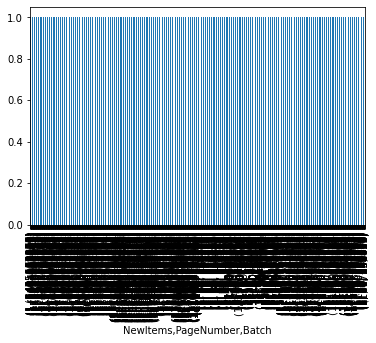

In [ ]:

df.head()
testdf = df.drop(columns=["DeltaTime"])
testdf = testdf.loc[df['PageNumber'] %10==0]
testdf = testdf.loc[testdf['NewItems'] == 1]
testdf.head()
testdf.value_counts().plot(x='PageNumber', y='NewItems',kind ='bar')



In [ ]:


CATEGORIES = ["Old","New"]
z = x[y.iloc[0:]==1]
pd.DataFrame(list(zip([0],[416100000000000])))
print(z.size)
z.head()

print(z[z['PageNumber'] == 274])

prediction = model.predict(z)
print(prediction)
print(CATEGORIES[int(prediction[0][0])])

53559
     PageNumber  DeltaTime   Batch
314         274    3257000     933
315         274    4872000    1964
341         274    4840000   39572
371         274    3590000   74206
409         274    3638000  108199
449         274    4872000  121070
488         274   19205000  138252
531         274    5299000  147056
568         274   16131000  152868
604         274   34663000  164788
558/558 [==============================] - 1s 1ms/step
[[0.2646781]
 [0.2646781]
 [0.2646781]
 ...
 [0.2646781]
 [0.2646781]
 [0.2646781]]
Old
